<a href="https://colab.research.google.com/github/RishabhSheoran/CS5446/blob/main/Paper2/Paper_2_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Deep Q Networks

<!-- **Before doing this, be sure you review the `README.md` file from the homework!** -->

<!-- **HUGE NOTE**: the third deliverable asks you to run Pong for several thousand steps.
Please start early, as the evaluation portion of this assignment can take many hours.
We provide some timing benchmarks for machines in the third deliverable. -->

In this part of the assignment, you will implement the Deep Q-Network algorithm
(DQN) [1], along with the Double DQN extension [2]. 
<!-- At a high level, the `dqn.py`
code builds a TensorFlow computational graph in the class initialization method.
Then, to train, it iterates through environment steps and model updates. -->

## Review

Recall from lecture that the DQN algorithm performs the following optimization:

\begin{equation}
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[ 
\Big(r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a) - Q_\theta(s_t,a_t)\Big)^2
\right]
\end{equation}

Here, $(s_t,a_t,r_t,s_{t+1})$ are batches of samples from the experience replay
buffer $D$, which is designed to store the past $N$ samples (where usually
$N=1,000,000$ for Atari benchmarks) so as to break correlation among the
training data used for updating $\theta$. In addition, we use $\theta$ to
represent the *current* or *online* network, whereas $\theta^-$
represents the *target* network. Both networks use the same architecture,
and we use $Q_\theta(s,a)$ or $Q_{\theta^-}(s,a)$ to denote which of the two
parameters is being applied to evaluate the state-action tuple $(s,a)$.

The target network starts off by getting matched to the current network, but
remains frozen (usually for thousands of steps) before getting updated again to
match the network. The process repeats throughout training, with the goal of
increasing the stability of the targets $r_t + \gamma \max_{a \in \mathcal{A}}
Q_{\theta^-}(s_{t+1},a)$. For more details, we recommend reading [1].

In *Double* DQN, the target value changes slightly. The new optimization
problem is:

\begin{equation}
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[ 
\Big(r_t + \gamma Q_{\theta^-} \Big( s_{t+1}, {\rm argmax}_{a\in \mathcal{A}} Q_\theta(s_{t+1},a) \Big)  - Q_\theta(s_t,a_t)\Big)^2
\right]
\end{equation}

Notice the key difference in the target terms, which we denote $Y_t^{\rm DQN}$
and $Y_t^{\rm DoubleDQN}$ following the notation in [2]. Explicitly, we
have

\begin{equation}
Y_t^{\rm DQN} = r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a)
\end{equation}

in DQN, and

\begin{equation}
Y_t^{\rm DoubleDQN} = r_t + \gamma
Q_{\theta^-} \Big( s_{t+1}, {\rm argmax}_{a\in \mathcal{A}} Q_\theta(s_{t+1},a) \Big)
\end{equation}

in DDQN. Intuitively, DDQN helps to mitigate the issue of over-optimistic values
from DQN. In DQN, for a given state $s$, the Q-network takes the maximum over
quantities $Q_{\theta^-}(s,a_k)$ for all actions $a_k \in \mathcal{A}$. In DDQN,
we consider the same $Q_{\theta^-}(s,a_k)$ values, yet are not guaranteed to
take the maximum one because the action selection is done by a different
network.  For more details, we recommend reading [2]. The paper also
covers the Double Q-Learning algorithm, which was originally developed in the
tabular settings.  The Double *Deep Q-Network* algorithm, which you need to implement in this assignment, is the minimal extension of DQN towards Double Q-Learning.

# Noted that you need to implement Double DQN in this assignment.

[1]: [DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf), read the Nature 2015 paper, not the NIPS 2013 workshop paper

[2]: [DDQN](https://arxiv.org/abs/1509.06461) at AAAI, 2016.


# DDQN Implementation


**You will need to write code in `DQN.ipynb` file in three specific spots.
These are clearly indicated with the comments `START OF YOUR CODE` and
`END OF YOUR CODE`.** Put your code between those comments. Concretely, they correspond to:

- Environment Stepping
- Training by computing the Bellman Error.

**See the comments in `DQN.ipynb`, which provide detailed instructions. You
should not need to modify any other files for this part of the assigment**. 

Some advice: implementing DQN can be tricky, and it is sometimes difficult to know if your algorithm is working immediately due to the many samples necessary for deep reinforcement learning. Thus, we advice:

- Do not engage in (extensive) hyperparmeter tuning. We provide
hyperparameters for you in `DQN.ipynb` for CartPole environment that
have empirically worked for our solutions. If you have the time, you may find it
helpful to tune the learning rate for CartPole.

# Other Considerations

As in the first part on policy gradients, you should test your code by running Jupyter notebook cells. Make sure that you don't change the cells, as the graders need consistency in seeing the results.

In [1]:
!pip install gym==0.10.5

     |████████████████████████████████| 1.5 MB 4.3 MB/s 
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581307 sha256=7b074da6e77d760d4658b2828dcee34dd4c1faf1810544b05ecdbe512f049326
  Stored in directory: /root/.cache/pip/wheels/7a/2c/df/a05b548a40fae16ca400ecbeda0067e1a296499c1fbd7e0c9a
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
import random, time, gym, sys
import gym.spaces
from gym.wrappers.monitor import Monitor
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from collections import namedtuple
import pickle
import time
import uuid
import os
import sys
from collections import deque

OptimizerSpec = namedtuple("OptimizerSpec", ["constructor", "kwargs", "lr_schedule"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set Up Hyperparameters

In [3]:
env='CartPole-v0'
seed=3
num_steps=5e4
double_q=True

if seed is None:
    seed = random.randint(0, 9999)
print('random seed = {}'.format(seed))
exp_name = 'double-dqn'

logdir = exp_name+ '_' +env+ '_' +time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('data_dqn', logdir)

def set_global_seeds(i):
    np.random.seed(i)
    random.seed(i)

env = gym.make(env)
set_global_seeds(seed)
env.seed(seed)
torch.manual_seed(seed)
expt_dir = os.path.join(logdir, "gym")
env = Monitor(env, expt_dir, force=True, video_callable=False)

random seed = 3
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
class DQN(nn.Module):

    def __init__(self, input_size, num_actions):
        super(DQN, self).__init__()
        self.dense1 = nn.Linear(input_size, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.tanh(self.dense1(x))
        x = F.tanh(self.dense2(x))
        out = self.dense3(x)
        return out

## Set Up Exploration Strategy

In [5]:
def linear_interpolation(l, r, alpha):
    return l + alpha * (r - l)

class PiecewiseSchedule(object):

    def __init__(self, endpoints, interpolation=linear_interpolation, outside_value=None):
        """Piecewise schedule.
        
        Parameters
        ----------
        endpoints: [(int, int)]
            list of pairs `(time, value)` meanining that schedule should output
            `value` when `t==time`. All the values for time must be sorted in
            an increasing order. When t is between two times, e.g. `(time_a, value_a)`
            and `(time_b, value_b)`, such that `time_a <= t < time_b` then value outputs
            `interpolation(value_a, value_b, alpha)` where alpha is a fraction of
            time passed between `time_a` and `time_b` for time `t`.
        interpolation: lambda float, float, float: float
            a function that takes value to the left and to the right of t according
            to the `endpoints`. Alpha is the fraction of distance from left endpoint to
            right endpoint that t has covered. See linear_interpolation for example.
        outside_value: float
            if the value is requested outside of all the intervals sepecified in
            `endpoints` this value is returned. If None then AssertionError is
            raised when outside value is requested.
        """
        idxes = [e[0] for e in endpoints]
        assert idxes == sorted(idxes)
        self._interpolation = interpolation
        self._outside_value = outside_value
        self._endpoints      = endpoints

    def value(self, t):
        """See Schedule.value"""
        for (l_t, l), (r_t, r) in zip(self._endpoints[:-1], self._endpoints[1:]):
            if l_t <= t and t < r_t:
                alpha = float(t - l_t) / (r_t - l_t)
                return self._interpolation(l, r, alpha)

        # t does not belong to any of the pieces, so doom.
        assert self._outside_value is not None
        return self._outside_value

exploration_schedule = PiecewiseSchedule([
        (0,   1.00),
        (5e3, 0.03),
        (1e4, 0.01),
    ], outside_value=0.01
)



## Set Up Replay Buffer

In [6]:
# ------------------------------------------------------------------------------
# REPLAY BUFFER
# ------------------------------------------------------------------------------

class BasicBuffer:

  def __init__(self, max_size):
      self.max_size = max_size
      self.buffer = deque(maxlen=max_size)

  def push(self, state, action, reward, next_state, done):
      experience = (state, action, np.array([reward]), next_state, done)
      self.buffer.append(experience)

  def sample(self, batch_size):
      state_batch = []
      action_batch = []
      reward_batch = []
      next_state_batch = []
      done_batch = []

      batch = random.sample(self.buffer, batch_size)

      for experience in batch:
          state, action, reward, next_state, done = experience
          state_batch.append(state)
          action_batch.append(action)
          reward_batch.append(reward)
          next_state_batch.append(next_state)
          done_batch.append(done)

      return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
      return len(self.buffer)

def get_wrapper_by_name(env, classname):
    currentenv = env
    while True:
        if classname in currentenv.__class__.__name__:
            return currentenv
        elif isinstance(env, gym.Wrapper):
            currentenv = currentenv.env
        else:
            raise ValueError("Couldn't find wrapper named %s"%classname)

## Run Q-Learning Algorithm

In [7]:
a = torch.Tensor([1])
a.item()

1.0

In [8]:
class QLearner(object):

    def __init__(self,
                 env,
                 q_func,
                 t_func,
                 optimizer_spec,
                 exploration,
                 replay_buffer_size,
                 batch_size,
                 gamma,
                 learning_starts,
                 target_update_freq,
                 grad_norm_clipping,
                 double_q=True,
                 max_steps=2e8,
                 cartpole=True):
        """Run Deep Q-learning algorithm.

        You can specify your own convnet using `q_func`.
        All schedules are w.r.t. total number of steps taken in the environment.

        Parameters
        ----------
        env: gym.Env
            gym environment to train on.
        q_func: function
            Model to use for computing the q function. 
        t_func: function
            Model to use for computing the target q function. 
        optimizer_spec: OptimizerSpec
            Specifying the constructor and kwargs, as well as learning rate schedule
            for the optimizer
        exploration: 
            exploration schedule
        replay_buffer_size: int
            How many memories to store in the replay buffer.
        batch_size: int
            How many transitions to sample each time experience is replayed.
        gamma: float
            Discount Factor
        learning_starts: int
            After how many environment steps to start replaying experiences
        target_update_freq: int
            How many experience replay rounds (not steps!) to perform between
            each update to the target Q network
        grad_norm_clipping: float or None
            If not None gradients' norms are clipped to this value.
        double_q: bool
            If True, use double Q-learning to compute target values. Otherwise, vanilla DQN.
            https://papers.nips.cc/paper/3964-double-q-learning.pdf
        max_steps: int
            Maximum number of training steps. The number of *frames* is 4x this
            quantity (modulo the initial random no-op steps).
        cartpole: bool
            If True, CartPole-v0.
        """
        assert type(env.observation_space) == gym.spaces.Box
        assert type(env.action_space)      == gym.spaces.Discrete
        self.q_func = q_func
        self.t_func = t_func
        self.max_steps = int(max_steps)
        self.target_update_freq = target_update_freq
        self.optimizer = optimizer_spec
        self.exploration = exploration
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_starts = learning_starts
        self.double_q = double_q
        self.cartpole = cartpole
        self.env = env
        self.replay_buffer = BasicBuffer(max_size=replay_buffer_size)

        self.input_shape = self.env.observation_space.shape # should be (4,)
        self.num_actions = self.env.action_space.n

        self.num_param_updates = 0
        self.mean_episode_reward      = -float('nan')
        self.std_episode_reward       = -float('nan')
        self.best_mean_episode_reward = -float('inf') 
        self.steps = []
        self.mean_rewards = []
        self.log_every_n_steps = 1000
        self.start_time = time.time()
        self.last_obs = self.env.reset()
        self.t = 0


    def step_env(self):
        """Step the env and store the transition.

        At this point, `self.last_obs` contains the latest observation that was
        recorded from the simulator. Here, your code
        needs to store this observation and outcome (reward, next observation,
        etc.) into the replay buffer while doing one step in the env simulator.

        At the end of this block of code, the simulator should have been
        advanced one step, the replay buffer should contain one more transition,
        and, `self.last_obs` must point to the new latest observation.

        Useful functions you'll need to call:

            self.env.step(action)
            self.replay_buffer.push(self.last_obs, action, reward, next_obs, done)

        This steps the environment forward one step. And:

            obs = self.env.reset()

        This resets the environment if you reached an episode boundary.  Call
        `self.env.reset()` to get a new observation if `done=True`. For CartPole, 
        this is guaranteed to start a new episode as they don't have a
        notion of 'ale.lives' in them.

        Don't forget to include epsilon greedy exploration!  
        """
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Hint: Don't forget to include epsilon greedy exploration!
        # if random.random() < self.exploration.value(self.t):
        #   ...
        # else:
        #   ...
        # ...
        # next_obs, _, _, _ = self.env.step(action)
        # Hint: Do not forget to update `self.last_obs` based on next observation (next_obs)
        # Hint: Call `self.env.reset()` to get a new observation and start a new episode if `done=True`.
        
        rate = self.exploration.value(self.t)
        if rate > random.random():
            # exploration
            action =  random.randrange(self.num_actions) 
        else:
            # exploitation
            with torch.no_grad():
                action = self.q_func(torch.from_numpy(self.last_obs).float().to(device)).argmax().item()   
        # print('action: ', action)
        action = torch.LongTensor([action]).to(device)
        next_obs, reward, done, _ = self.env.step(action.item())

        self.replay_buffer.push(self.last_obs, action, reward, next_obs, done)
        self.last_obs = next_obs

        if done:
            self.last_obs = self.env.reset()

        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------

    def update_model(self):
        """Perform experience replay and train the network.

        This is only done if the replay buffer contains enough samples for us to
        learn something useful -- until then, the model will not be initialized
        and random actions should be taken.  Training consists of four steps:
        
        3.a: Use the replay buffer to sample a batch of transitions. See the
        replay buffer code for function definitions. You may use thi function:

          self.replay_buffer.sample(self.batch_size)

        3.b: Compute the total Bellman error in a batch. You can use MSE loss to
        achieve it.
        
        3.c: Perform a gradient step and update the network parameters to reduce
        total_error. 
        
        3.d: Periodically update the target network (self.t_func) every 
        `self.target_update_freq` steps.

        Hint: You can also use `param.grad.data.clamp` to clip gradient, where 
        `param in self.q_func.parameters()`.
        """
        if (self.t > self.learning_starts and \
            len(self.replay_buffer) > self.batch_size):

            # ------------------------------------------------------------------
            # START OF YOUR CODE
            # ------------------------------------------------------------------
            #  

            state_batch, actions_tensor_list, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(self.batch_size)
            
            action_batch = []
            for t in actions_tensor_list:
                action_batch.append(t.item())
            action_batch = torch.from_numpy(np.array(action_batch)).long().to(device)
            state_batch  = torch.from_numpy(np.array(state_batch)).float().to(device)
            reward_batch = torch.from_numpy(np.array(reward_batch)).float().to(device)
            next_state_batch = torch.from_numpy(np.array(next_state_batch)).float().to(device) 
            done_batch = torch.from_numpy(np.array(done_batch)).long().to(device)

            current_q_values = self.q_func(state_batch).gather(dim=1, index=action_batch.unsqueeze(-1))
            inner_action = self.t_func(next_state_batch).argmax(dim=1).detach()
            target_q_values = reward_batch + self.gamma * self.t_func(next_state_batch).gather(dim=1, index=inner_action.unsqueeze(-1)) * (1-done_batch).unsqueeze(-1)

            loss = F.mse_loss(current_q_values, target_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            for param in self.q_func.parameters():
                param.grad.data.clamp
            self.optimizer.step()

            if self.t % self.target_update_freq == 0:
                self.t_func.load_state_dict(self.q_func.state_dict())

            # ------------------------------------------------------------------
            # END OF YOUR CODE
            # ------------------------------------------------------------------
            self.num_param_updates += 1
        self.t += 1

    def log_progress(self):
        episode_rewards = get_wrapper_by_name(self.env, "Monitor").get_episode_rewards()

        if len(episode_rewards) > 0:
            self.mean_episode_reward = np.mean(episode_rewards[-10:])
            self.std_episode_reward  = np.std(episode_rewards[-10:])
        if len(episode_rewards) > 10:
            self.best_mean_episode_reward = \
                max(self.best_mean_episode_reward, self.mean_episode_reward)

        if self.t % self.log_every_n_steps == 0:
            self.steps.append(self.t)
            self.mean_rewards.append(self.mean_episode_reward)
            hours = (time.time() - self.start_time) / (60.*60.)
            print("Steps: ",                 self.t)
            print("Avg_Last_10_Episodes", self.mean_episode_reward)
            print("Std_Last_10_Episodes", self.std_episode_reward)
            print("Best_Avg_10_Episodes", self.best_mean_episode_reward)
            print("Num_Episodes",          len(episode_rewards))
            print("Exploration_Epsilon",   self.exploration.value(self.t))
            print("Elapsed_Time_Hours",    hours)

    def checkSolveEnv(self):
        if self.mean_episode_reward > 195:
            return 1, self.t
        return 0, self.t


In [9]:
def dqn_learn(*args, **kwargs):
    flag = 0
    alg = QLearner(*args, **kwargs)
    while True:
        # 
        alg.step_env()
        alg.update_model()
        alg.log_progress()
        solved, steps = alg.checkSolveEnv()
        if solved and not flag:
            print('Solved the environment after {} steps'.format(steps))
            flag = 1
        if alg.t > alg.max_steps:
            print("\nt = {} exceeds max_steps = {}".format(alg.t, alg.max_steps))
            break
    return alg.steps, alg.mean_rewards

In [10]:
n_actions = env.action_space.n

policy_net = DQN(4, n_actions).to(device)
target_net = DQN(4, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=4e-4)

steps, mean_rewards = dqn_learn(
    env=env,
    q_func=policy_net,
    t_func=target_net,
    optimizer_spec=optimizer,
    exploration=exploration_schedule,
    replay_buffer_size=50000,
    batch_size=100,
    gamma=0.99,
    learning_starts=1000,
    target_update_freq=100,
    grad_norm_clipping=10,
    double_q=double_q,
    max_steps=num_steps,
    cartpole=True
    )

# env.close()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Steps:  1000
Avg_Last_10_Episodes 27.7
Std_Last_10_Episodes 14.269197594819408
Best_Avg_10_Episodes 28.1
Num_Episodes 42
Exploration_Epsilon 0.806
Elapsed_Time_Hours 0.0001252004173066881
Steps:  2000
Avg_Last_10_Episodes 15.8
Std_Last_10_Episodes 5.455272678794342
Best_Avg_10_Episodes 29.1
Num_Episodes 94
Exploration_Epsilon 0.612
Elapsed_Time_Hours 0.001396564973725213
Steps:  3000
Avg_Last_10_Episodes 77.2
Std_Last_10_Episodes 44.75667547975385
Best_Avg_10_Episodes 77.2
Num_Episodes 110
Exploration_Epsilon 0.41800000000000004
Elapsed_Time_Hours 0.0023452643553415935
Steps:  4000
Avg_Last_10_Episodes 142.3
Std_Last_10_Episodes 25.83427955256349
Best_Avg_10_Episodes 142.3
Num_Episodes 117
Exploration_Epsilon 0.22399999999999998
Elapsed_Time_Hours 0.003303652140829298
Steps:  5000
Avg_Last_10_Episodes 144.4
Std_Last_10_Episodes 9.697422337920525
Best_Avg_10_Episodes 149.3
Num_Episodes 124
Exploration_Epsilon 0.03
Elapsed_Time_Hours 0.004282624324162801
Steps:  6000
Avg_Last_10_Episodes

Text(0, 0.5, 'Average Return')

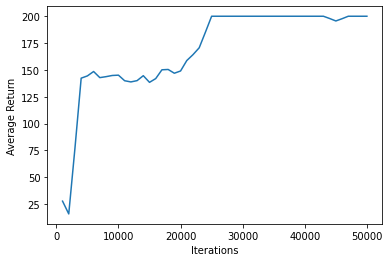

In [11]:
import matplotlib.pyplot as plt
plt.plot(steps, mean_rewards)
plt.xlabel("Iterations")
plt.ylabel("Average Return")